# Exploratory Data Analysis - Dense NN 
This notebook provides functionality to manually explore the results of processing the Tiles dataset and viewing the outcome. 

In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import activations
from tensorflow.keras import initializers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

## Helper Functions

The standard <code>read_data()</code> function seen throughout the project. designed to simplify and standardize the data reading process. <br/>In addition the _Global_ variables associated with its function are defined along with the relitive paths to the data files.<br/>__NOTE:__ in a business environment this function would be placed into a pythin module and imported. Here it is included into the notebook to provide full transparency. 

In [2]:
# required modules
import numpy as np
import pandas as pd
import sqlite3
from sklearn import preprocessing
import colorsys

# groups
COLOURS      = 10
PALETTES     = 11
LRG_PALETTES = 12
IMAGE        = 13
TILES        = 14

# sets
TRAIN        = 20
TEST         = 21
VALIDATE     = 22

# targets
ARTIST       = 30
GENRE        = 31
STYLE        = 32

# array
DATA         = 40
CATAGORY     = 41
CATAGORY_NUM = 42
IMAGE_TAG    = 43
TILE_INDEX   = 44

# colour systems
HLS          = 50
RGB          = 51
RAW          = 52

# an overly complicated method of defining the data file path
data_file  = {COLOURS      : {TRAIN    : {ARTIST : "./data/colour_sets/artist_train_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_train_colours.npz",
                                          STYLE  : "./data/colour_sets/style_train_colours.npz"},
                              TEST     : {ARTIST : "./data/colour_sets/artist_test_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_test_colours.npz",
                                          STYLE  : "./data/colour_sets/style_test_colours.npz"} ,
                              VALIDATE : {ARTIST : "./data/colour_sets/artist_validation_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_validation_colours.npz",
                                          STYLE  : "./data/colour_sets/style_validation_colours.npz"}},
              PALETTES     : {TRAIN    : {ARTIST : "./data/palette_sets/artist_train_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_train_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_train_palettes.npz"} ,
                              TEST     : {ARTIST : "./data/palette_sets/artist_test_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_test_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_test_palettes.npz"} ,
                              VALIDATE : {ARTIST : "./data/palette_sets/artist_validation_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_validation_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_validation_palettes.npz"}},
              LRG_PALETTES : {TRAIN    : {ARTIST : "./data/large_palette_sets/artist_train_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_train_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_train_palettes.npz"} ,
                              TEST     : {ARTIST : "./data/large_palette_sets/artist_test_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_test_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_test_palettes.npz"} ,
                              VALIDATE : {ARTIST : "./data/large_palette_sets/artist_validation_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_validation_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_validation_palettes.npz"}},
              IMAGE        : {TRAIN    : {ARTIST : "./data/full_image_feature_sets/artist_train_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_train_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_train_features.npz"} ,
                              TEST     : {ARTIST : "./data/full_image_feature_sets/artist_test_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_test_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_test_features.npz"} ,
                              VALIDATE : {ARTIST : "./data/full_image_feature_sets/artist_validation_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_validation_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_validation_features.npz"}},
              TILES        : {TRAIN    : {ARTIST : "./data/feature_sets/artist_train_features.npz",
                                          GENRE  : "./data/feature_sets/genre_train_features.npz",
                                          STYLE  : "./data/feature_sets/style_train_features.npz"} ,
                              TEST     : {ARTIST : "./data/feature_sets/artist_test_features.npz",
                                          GENRE  : "./data/feature_sets/genre_test_features.npz",
                                          STYLE  : "./data/feature_sets/style_test_features.npz"} ,
                              VALIDATE : {ARTIST : "./data/feature_sets/artist_validation_features.npz",
                                          GENRE  : "./data/feature_sets/genre_validation_features.npz",
                                          STYLE  : "./data/feature_sets/style_validation_features.npz"}}}

# Create a DB connection between python and the file system
conn = sqlite3.connect("./data/database/artist.db")

# the fuction that provides a standard data read method
def read_data(data_group, data_set, data_target, data_type, colour_system = RGB):
    
    # read the data file
    data = np.load(data_file[data_group][data_set][data_target], allow_pickle=True)

    # if tile index is requested
    if   data_type    == TILE_INDEX:
        # when group is tiles, return the tile indexes
        if data_group == TILES:
            return pd.DataFrame(data["arr_3"], columns = {"tile_index"})
        # otherwise, just return an emtpy dataset
        else:
            return pd.DataFrame(columns = {"tile_index"})
    # if image tags are requested
    elif data_type == IMAGE_TAG:
        return pd.DataFrame(data["arr_2"], columns = {"image_tag"})
    # if catagory data is requested
    elif data_type == CATAGORY:
        return pd.DataFrame(data["arr_1"], columns = {"catagory"})
    # if catagory_num is requested
    elif data_type == CATAGORY_NUM:
        # select data for the appropriate lookup table
        if   data_target == ARTIST: 
            query_string = "SELECT ID, NAME  AS VALUE FROM ARTIST"
        elif data_target == GENRE:
            query_string = "SELECT ID, GENRE AS VALUE FROM GENRE"
        else:
            query_string = "SELECT ID, STYLE AS VALUE FROM STYLE" 
        # build the lookup table
        lookup = pd.read_sql_query(query_string, conn)
        # get the catagory data
        data   = pd.DataFrame(data["arr_1"], columns = {"catagory"})
        # convert the catagory text labels to numeric catagory ids
        return pd.DataFrame(data["catagory"].apply(lambda x: lookup[lookup["VALUE"] == x]["id"].values[0]))
    # data requested
    elif data_group == COLOURS:
        # reshape the data and normalize
        return pd.DataFrame(preprocessing.normalize(data["arr_0"].reshape(data["arr_0"].shape[0],data["arr_0"].shape[1] * data["arr_0"].shape[2])))
    elif data_group == PALETTES or data_group == LRG_PALETTES:

        # extract the colour data
        colour_data = data["arr_0"]
        
        # find the datas dimensions
        records, _, palette_length, palette_layers = np.shape(colour_data)
        
        # reshape
        colour_data = colour_data.reshape(records * palette_length, palette_layers)
        
        # convert to a dataframe
        colour_data_df = pd.DataFrame(colour_data, columns =["r","g","b"])
        
        # process the data with different colour systems
        
        # hue, luminance, saturation
        if colour_system == HLS:
            
            # define a dataframe to hold the hls values
            hls_data_df = pd.DataFrame(columns =["h","l","s"])

            # loop through each record
            for row in colour_data_df.iterrows():
                
                # extract the r,g,b values and devide them by 255 ready to convert
                r, g, b = row[1].values/255

                # convert the values and add them to the dataframe
                hls_data_df.loc[len(hls_data_df)] = colorsys.rgb_to_hls(r, g, b)
            
            # create datasets and normalize
            hue        = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["h"]).reshape(records, palette_length)))
            luminance  = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["l"]).reshape(records, palette_length)))
            saturation = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["s"]).reshape(records, palette_length)))  
            
            # return values
            return hue, luminance, saturation
            
        # red, green, blue unnormalized
        elif colour_system == RAW:
            red   = pd.DataFrame(np.array(colour_data_df["r"]).reshape(records, palette_length))
            green = pd.DataFrame(np.array(colour_data_df["g"]).reshape(records, palette_length))
            blue  = pd.DataFrame(np.array(colour_data_df["b"]).reshape(records, palette_length))
            
            # return values
            return red, green, blue            
            
        # red, green, blue normalized- (default)
        else:
    
            # create datasets and normalize
            red   = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["r"]).reshape(records, palette_length)))
            green = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["g"]).reshape(records, palette_length)))
            blue  = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["b"]).reshape(records, palette_length)))
            
            # return values
            return red, green, blue

    elif data_group == IMAGE:
        # reshape the data and normalize
        return pd.DataFrame(preprocessing.normalize(data["arr_0"].reshape(data["arr_0"].shape[0],data["arr_0"].shape[2])))
    else:
        # normalize the data
        return pd.DataFrame(preprocessing.normalize(data["arr_0"])) 

The <code>get_colours()</code> function provides a list of colours the length of the value <code>no_of_colours</code>. This can be useful for consisten colours when used across multiple plots. 

In [3]:
# required modules
import random

# define colours used 
def get_colours(no_of_colours):
    
    # consistent randomness
    random.seed(42)
    
    # colour list
    colours = []

    # generate colours
    for i in range(no_of_colours):
        colours.append('#%06X' % random.randint(0, 0xFFFFFF))
    
    # return the colour list
    return colours

Generate sorted lists of _Artists, Genres_ & _Styles_. These are used in a variety of situations. These functions ensure that the lists are always defined in the same order.

In [4]:
# define data lists
artists = list(set(read_data(COLOURS, TRAIN, ARTIST, CATAGORY)["catagory"]))
styles  = list(set(read_data(COLOURS, TRAIN, STYLE,  CATAGORY)["catagory"]))
genres  = list(set(read_data(COLOURS, TRAIN, GENRE,  CATAGORY)["catagory"]))

# sort the lists
artists.sort()
styles.sort()
genres.sort()

Generate a one dimensional array of zeros the length of the target set. Unlike <code>dummy</code> this array of zeros is the full length of the target set and not the length of the provided data.

In [5]:
def generate_target_zeros(data, target_type):
    
    # generate a row of zeros with the target value set to 1
    def row_zeros(value):
        zeros_array = np.zeros((1,len(target_type)))
        zeros_array[0, target_type.index(value) ] = 1
        return zeros_array
    
    # generate all of the target rows
    array_of_rows = [row_zeros(x) for x in data["catagory"]]
    
    # return a target dataframe
    return pd.DataFrame(np.reshape(array_of_rows,(len(array_of_rows),len(target_type)) )).astype(int)

## Configurable Models¶
We have 4 Model types
- Input & Output layers only
- Input & Output layers, plus one Hidden layer
- Input & Output layers, plus two Hidden layers
- Input & Output layers, plus three Hidden layers </br>

Models with one or more hidden layers can be reconfigured by passing activation value with the <code>activation_n</code> parameters.

In [6]:
def get_model_1(data_width = 1280,):
    model = Sequential()
    model.add(Dense(len(catagories), 
                     input_shape        = (data_width,),
                     kernel_initializer = initializers.VarianceScaling(scale = 2.0, 
                                                                       seed  = 42)))
    model.add(Dense(len(catagories), 
                     activation         = "softmax",
                     kernel_initializer = initializers.VarianceScaling(scale = 1.0, 
                                                                       seed  = 42)))
    return model

In [7]:
def get_model_2(data_width = 1280, activation_1 = "relu"):
    model = Sequential()
    model.add(Dense(data_width // 2, 
                     input_shape        = (data_width,),
                     kernel_initializer = initializers.VarianceScaling(scale = 2.0, 
                                                                       seed  = 42)))

    model.add(Dense(data_width // 4, 
                     input_shape        = (data_width // 2,), 
                     activation         = activation_1))

    model.add(Dense( len(catagories), 
                     activation         = "softmax",
                     kernel_initializer = initializers.VarianceScaling(scale = 1.0, 
                                                                       seed  = 42)))
    return model

In [8]:
def get_model_3(data_width = 1280, activation_1 = "relu", activation_2 = "relu"):
    model = Sequential()
    model.add(Dense( data_width // 2, 
                     input_shape        = (data_width,),
                     kernel_initializer = initializers.VarianceScaling(scale = 2.0, 
                                                                       seed  = 42)))

    model.add(Dense( data_width // 4, 
                     input_shape        = (data_width // 2,), 
                     activation         = activation_1))

    model.add(Dense( data_width // 8, 
                     input_shape        = (data_width // 4,), 
                     activation         = activation_2))

    model.add(Dense( len(catagories), 
                     activation         = "softmax",
                     kernel_initializer = initializers.VarianceScaling(scale = 1.0, 
                                                                       seed  = 42)))
    return model

In [9]:
def get_model_4(data_width = 1280, activation_1 = "relu", activation_2 = "relu", activation_3 = "relu"):
    model = Sequential()
    model.add(Dense( data_width // 2, 
                     input_shape        = (data_width,),
                     kernel_initializer = initializers.VarianceScaling(scale = 2.0, 
                                                                       seed  = 42)))

    model.add(Dense( data_width // 4, 
                     input_shape        = (data_width // 2,), 
                     activation         = activation_1))

    model.add(Dense( data_width // 8, 
                     input_shape        = (data_width // 4,), 
                     activation         = activation_2))

    model.add(Dense( data_width // 16, 
                     input_shape        = (data_width // 8,), 
                     activation         = activation_3))
    
    model.add(Dense( len(catagories), 
                     activation         = "softmax",
                     kernel_initializer = initializers.VarianceScaling(scale = 1.0, 
                                                                       seed  = 42)))
    return model

The <code>model_test</code> function provides the testbed functionality for the various models, hayperparameters and data sets and targets.

In [10]:
def model_test(model_id, activation_1 = "", activation_2 = "", activation_3 = "", optimizer_name = "", group = TILES, target = ARTIST, show_plots = True, show_accuracy = True, show_summary = True):
    
    # import the training data
    X_train = read_data(group, TRAIN,    target, DATA)
    y_train = generate_target_zeros(read_data(group, TRAIN,    target, CATAGORY), catagories)
    
    # import the test data
    X_test  = read_data(group, TEST,     target, DATA)
    y_test  = generate_target_zeros(read_data(group, TEST,     target, CATAGORY), catagories)
    
    # import the validataion data
    X_valid = read_data(group, VALIDATE, target, DATA)
    y_valid = generate_target_zeros(read_data(group, VALIDATE, target, CATAGORY), catagories)
    
    # select the model
    if model_id == 1:
        model = get_model_1(len(X_train.columns))
    elif model_id == 2:
        model = get_model_2(len(X_train.columns), activation_1 = activation_1)
    elif model_id == 3:
        model = get_model_3(len(X_train.columns), activation_1 = activation_1, activation_2 = activation_2)
    else:
        model = get_model_4(len(X_train.columns), activation_1 = activation_1, activation_2 = activation_2, activation_3 = activation_3)
    
    # select the optimizer
    if   optimizer_name == "ftrl":
        optimizer = keras.optimizers.Ftrl(    lr = 0.01)
    elif optimizer_name == "rmsprop":
        optimizer = keras.optimizers.RMSprop( lr = 0.01)
    elif optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(    lr = 0.01)
    elif optimizer_name == "adadelta":
        optimizer = keras.optimizers.Adadelta(lr = 0.01)
    elif optimizer_name == "adagrad":
        optimizer = keras.optimizers.Adagrad( lr = 0.01)
    elif optimizer_name == "adamax":
        optimizer = keras.optimizers.Adamax(  lr = 0.01)
    elif optimizer_name == "nadam":
        optimizer = keras.optimizers.Nadam(   lr = 0.01)
    else:
        optimizer = keras.optimizers.SGD(     lr = 0.01, momentum = 0.9)
        optimizer_name = "sgd"
    
    # set the pressing batch size
    batch_size = 256

    # compile the model
    model.compile( loss      = keras.losses.binary_crossentropy,
                   optimizer = optimizer,  
                   metrics   =['accuracy'])

    # Rescale train and validation data
    scaler               = StandardScaler()
    X_train_preprocessed = scaler.fit_transform(X_train.astype(float))
    X_test_preprocessed  = scaler.transform(    X_test.astype( float))
    X_valid_preprocessed = scaler.transform(    X_valid.astype(float))
    
    # fit the model
    history = model.fit(X_train_preprocessed,
                          y_train,
                          batch_size       = batch_size, 
                          validation_split = 0.2,
                          epochs           = 25,
                          shuffle          = True,
                          validation_data  = (X_valid_preprocessed, y_valid))
    
    # make a prediction
    prediction_results       = model.predict(X_test_preprocessed)
    df_prediction_results    = pd.DataFrame(prediction_results)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size = batch_size)
    
    if show_plots:
        
        # Create two plots: one for the loss value, one for the accuracy
        fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

        # plot accuracy values
        ax1.plot(history.history["loss"],     label = "train loss")
        ax1.plot(history.history["val_loss"], label ="val loss")
        ax1.set_title("Validation loss {:.3f} (mean last 3)".format(np.mean(history.history["val_loss"][-3:]))) # last three values
        ax1.set_xlabel("epoch")
        ax1.set_ylabel("loss value")
        ax1.legend()

        # plot accuracy values
        ax2.plot(history.history["acc"], label="train acc")
        ax2.plot(history.history["val_acc"], label="val acc")
        ax2.set_title("Validation accuracy {:.3f} (mean last 3)".format(np.mean(history.history["val_acc"][-3:]))) # last three values
        
        ax2.set_xlabel("epoch")
        ax2.set_ylabel("accuracy")
        ax2.legend()
        plt.show()
        
    if show_accuracy:
        
        print("Test loss: {:.2f}".format(test_loss)) 
        print("Test accuracy: {:.2f}%".format(100 * test_accuracy)) 
    
    if show_summary:
        model.summary()
        print("Parameters - model_id: {}, activation_1: {}, activation_2: {}, activation_3: {}, optimizer: {},".format(model_id, activation_1, activation_2, activation_3, optimizer_name)) 
        print("_________________________________________________________________\n\n\n\n\n")

## Test the Models
This section of the notebook allows the user to experiment with:
- Model layer count.
- Data sets.
- Targets.
- Activation hyperparameters.
- Opermizer Hyperparameters. </br>

This was used to help _rough out_ which setting work best with which data in preparation for for the hyperparameter evaluation. A small sample selection of tests has been left in place to demonstrate its use.

Here are some examples using the __COLOURS__ data to find __ARTISTS__.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2314 samples, validate on 297 samples
Epoch 1/25
2314/2314 [==============================] - 0s 73us/sample - loss: 0.3356 - acc: 0.9138 - val_loss: 0.2945 - val_acc: 0.9235
Epoch 2/25
2314/2314 [==============================] - 0s 12us/sample - loss: 0.2810 - acc: 0.9241 - val_loss: 0.2706 - val_acc: 0.9250
Epoch 3/25
2314/2314 [==============================] - 0s 14us/sample - loss: 0.2615 - acc: 0.9253 - val_loss: 0.2580 - val_acc: 0.9278
Epoch 4/25
2314/2314 [==============================] - 0s 12us/sample - loss: 0.2478 - acc: 0.9272 - val_loss: 0.2480 - val_acc: 0.9293
Epoch 5/25
2314/2314 [==============================] - 0s 14us/sample - loss: 0.2392 - acc: 0.9278 - val_loss: 0.2421 - val_acc: 0.9295
Epoch 6/25
2314/2314 [==============================] - 0s 12us/sample - loss: 0.2323 - acc: 

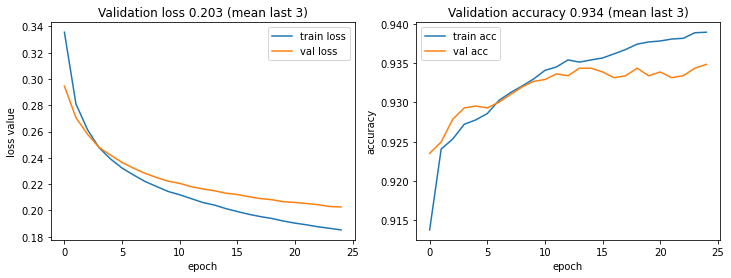

Test loss: 0.24
Test accuracy: 92.86%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                10766     
_________________________________________________________________
dense_1 (Dense)              (None, 14)                210       
Total params: 10,976
Trainable params: 10,976
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: , activation_2: , activation_3: , optimizer: sgd,
_________________________________________________________________





Train on 2314 samples, validate on 297 samples
Epoch 1/25
2314/2314 [==============================] - 0s 53us/sample - loss: 0.3112 - acc: 0.9249 - val_loss: 0.2843 - val_acc: 0.9274
Epoch 2/25
2314/2314 [==============================] - 0s 18us/sample - loss: 0.2484 - acc: 0.9277 - val_loss: 0.2336 - val_acc: 0

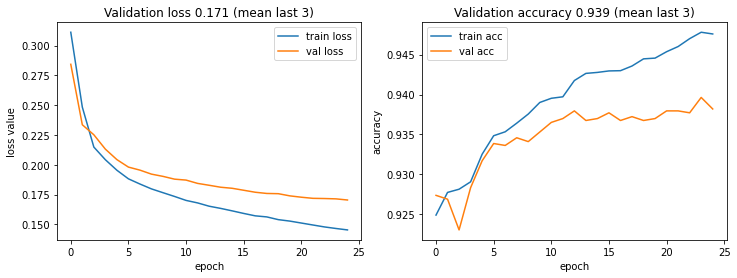

Test loss: 0.25
Test accuracy: 92.86%
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 384)               295296    
_________________________________________________________________
dense_3 (Dense)              (None, 192)               73920     
_________________________________________________________________
dense_4 (Dense)              (None, 14)                2702      
Total params: 371,918
Trainable params: 371,918
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: , activation_3: , optimizer: sgd,
_________________________________________________________________





Train on 2314 samples, validate on 297 samples
Epoch 1/25
2314/2314 [==============================] - 0s 56us/sample - loss: 0.2960 - acc: 0.9222 - val_loss: 0.2700 - val_acc

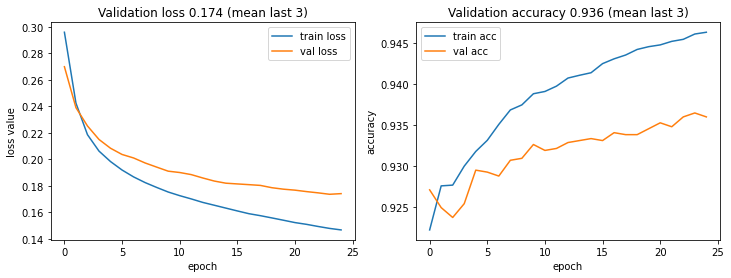

Test loss: 0.25
Test accuracy: 92.86%
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 384)               295296    
_________________________________________________________________
dense_6 (Dense)              (None, 192)               73920     
_________________________________________________________________
dense_7 (Dense)              (None, 96)                18528     
_________________________________________________________________
dense_8 (Dense)              (None, 14)                1358      
Total params: 389,102
Trainable params: 389,102
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 3, activation_1: relu, activation_2: elu, activation_3: , optimizer: sgd,
_________________________________________________________________





Train on 2314 samples, validate on 297 s

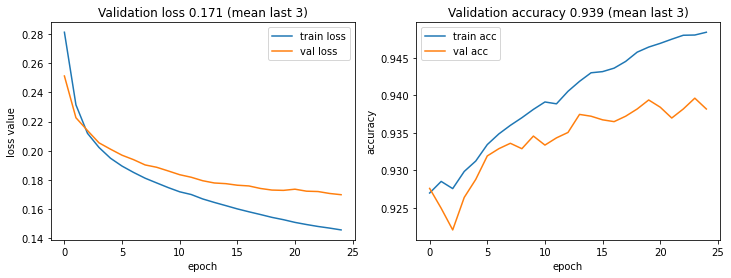

Test loss: 0.24
Test accuracy: 92.86%
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 384)               295296    
_________________________________________________________________
dense_10 (Dense)             (None, 192)               73920     
_________________________________________________________________
dense_11 (Dense)             (None, 96)                18528     
_________________________________________________________________
dense_12 (Dense)             (None, 48)                4656      
_________________________________________________________________
dense_13 (Dense)             (None, 14)                686       
Total params: 393,086
Trainable params: 393,086
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 4, activation_1: relu, activation_2: selu, activation

In [11]:
# set the labelling catagories
catagories = artists

# valid activation parameter valuess "relu", "sigmoid", "tanh", "selu", "elu"
# valid optimizer  parameter values  "sgd", "rmsprop", "adam", "adadelta", "adagrad", "adamax", "nadam", "ftrl"
# experiment with values
model_test(1, group = COLOURS, target = ARTIST,                                                                     optimizer_name = "sgd")
model_test(2, group = COLOURS, target = ARTIST, activation_1 = "relu",                                              optimizer_name = "sgd")
model_test(3, group = COLOURS, target = ARTIST, activation_1 = "relu", activation_2 = "elu",                        optimizer_name = "sgd")
model_test(4, group = COLOURS, target = ARTIST, activation_1 = "relu", activation_2 = "selu", activation_3 = "elu", optimizer_name = "sgd")

Here are some examples using the __TILES__ data to find __GENRES__.

Train on 148096 samples, validate on 19008 samples
Epoch 1/25
148096/148096 [==============================] - 3s 18us/sample - loss: 0.1508 - acc: 0.9637 - val_loss: 0.1378 - val_acc: 0.9635
Epoch 2/25
148096/148096 [==============================] - 3s 18us/sample - loss: 0.1264 - acc: 0.9647 - val_loss: 0.1261 - val_acc: 0.9642
Epoch 3/25
148096/148096 [==============================] - 3s 17us/sample - loss: 0.1166 - acc: 0.9654 - val_loss: 0.1199 - val_acc: 0.9646
Epoch 4/25
148096/148096 [==============================] - 3s 17us/sample - loss: 0.1104 - acc: 0.9659 - val_loss: 0.1160 - val_acc: 0.9649
Epoch 5/25
148096/148096 [==============================] - 3s 17us/sample - loss: 0.1061 - acc: 0.9662 - val_loss: 0.1130 - val_acc: 0.9652
Epoch 6/25
148096/148096 [==============================] - 3s 18us/sample - loss: 0.1029 - acc: 0.9665 - val_loss: 0.1110 - val_acc: 0.9653
Epoch 7/25
148096/148096 [==============================] - 3s 17us/sample - loss: 0.1007 - acc: 0.9668

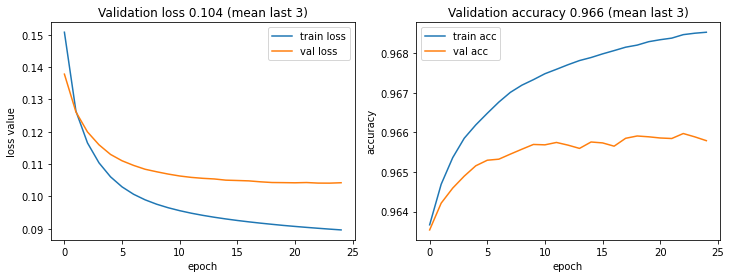

Test loss: 0.14
Test accuracy: 96.43%
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 28)                35868     
_________________________________________________________________
dense_15 (Dense)             (None, 28)                812       
Total params: 36,680
Trainable params: 36,680
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: , activation_2: , activation_3: , optimizer: sgd,
_________________________________________________________________





Train on 148096 samples, validate on 19008 samples
Epoch 1/25
148096/148096 [==============================] - 3s 23us/sample - loss: 0.1229 - acc: 0.9641 - val_loss: 0.1150 - val_acc: 0.9643
Epoch 2/25
148096/148096 [==============================] - 3s 22us/sample - loss: 0.1067 - acc: 0.9655 - val_loss: 0.109

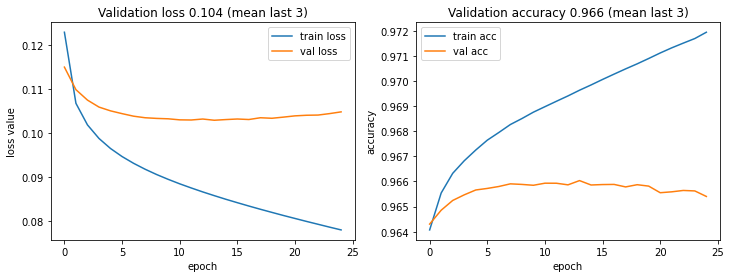

Test loss: 0.15
Test accuracy: 96.43%
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 640)               819840    
_________________________________________________________________
dense_17 (Dense)             (None, 320)               205120    
_________________________________________________________________
dense_18 (Dense)             (None, 28)                8988      
Total params: 1,033,948
Trainable params: 1,033,948
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: , activation_3: , optimizer: sgd,
_________________________________________________________________





Train on 148096 samples, validate on 19008 samples
Epoch 1/25
148096/148096 [==============================] - 3s 23us/sample - loss: 0.1220 - acc: 0.9642 - val_loss: 0.11

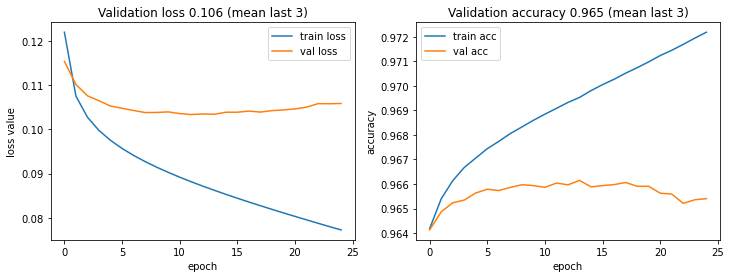

Test loss: 0.15
Test accuracy: 96.43%
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 640)               819840    
_________________________________________________________________
dense_20 (Dense)             (None, 320)               205120    
_________________________________________________________________
dense_21 (Dense)             (None, 160)               51360     
_________________________________________________________________
dense_22 (Dense)             (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 3, activation_1: relu, activation_2: elu, activation_3: , optimizer: sgd,
_________________________________________________________________





Train on 148096 samples, validate on

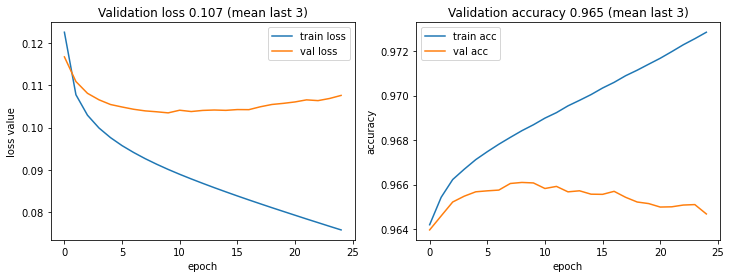

Test loss: 0.14
Test accuracy: 96.43%
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 640)               819840    
_________________________________________________________________
dense_24 (Dense)             (None, 320)               205120    
_________________________________________________________________
dense_25 (Dense)             (None, 160)               51360     
_________________________________________________________________
dense_26 (Dense)             (None, 80)                12880     
_________________________________________________________________
dense_27 (Dense)             (None, 28)                2268      
Total params: 1,091,468
Trainable params: 1,091,468
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 4, activation_1: relu, activation_2: selu, activa

In [12]:
# set the labelling catagories
catagories = genres

# experiment with values
model_test(1, group = TILES, target = GENRE,                                                                     optimizer_name = "sgd")
model_test(2, group = TILES, target = GENRE, activation_1 = "relu",                                              optimizer_name = "sgd")
model_test(3, group = TILES, target = GENRE, activation_1 = "relu", activation_2 = "elu",                        optimizer_name = "sgd")
model_test(4, group = TILES, target = GENRE, activation_1 = "relu", activation_2 = "selu", activation_3 = "elu", optimizer_name = "sgd")

Here are some examples using the __COLOURS__ data to find __STYLES__.

Train on 166720 samples, validate on 21760 samples
Epoch 1/25
166720/166720 [==============================] - 3s 19us/sample - loss: 0.1390 - acc: 0.9657 - val_loss: 0.1256 - val_acc: 0.9663
Epoch 2/25
166720/166720 [==============================] - 3s 17us/sample - loss: 0.1155 - acc: 0.9673 - val_loss: 0.1162 - val_acc: 0.9669
Epoch 3/25
166720/166720 [==============================] - 3s 18us/sample - loss: 0.1074 - acc: 0.9681 - val_loss: 0.1112 - val_acc: 0.9671
Epoch 4/25
166720/166720 [==============================] - 3s 17us/sample - loss: 0.1026 - acc: 0.9686 - val_loss: 0.1077 - val_acc: 0.9674
Epoch 5/25
166720/166720 [==============================] - 3s 17us/sample - loss: 0.0991 - acc: 0.9690 - val_loss: 0.1053 - val_acc: 0.9675
Epoch 6/25
166720/166720 [==============================] - 3s 18us/sample - loss: 0.0965 - acc: 0.9693 - val_loss: 0.1036 - val_acc: 0.9676
Epoch 7/25
166720/166720 [==============================] - 3s 17us/sample - loss: 0.0944 - acc: 0.9695

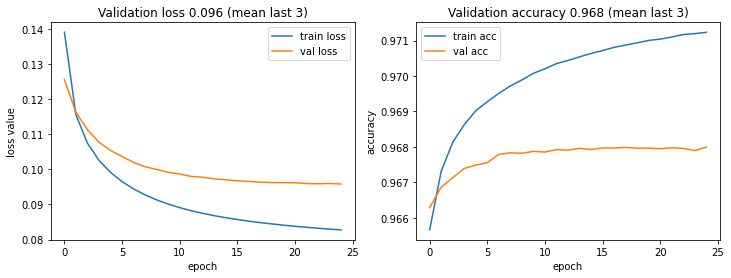

Test loss: 0.13
Test accuracy: 96.55%
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 29)                37149     
_________________________________________________________________
dense_29 (Dense)             (None, 29)                870       
Total params: 38,019
Trainable params: 38,019
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: , activation_2: , activation_3: , optimizer: sgd,
_________________________________________________________________





Train on 166720 samples, validate on 21760 samples
Epoch 1/25
166720/166720 [==============================] - 4s 24us/sample - loss: 0.1159 - acc: 0.9662 - val_loss: 0.1076 - val_acc: 0.9665
Epoch 2/25
166720/166720 [==============================] - 4s 22us/sample - loss: 0.0992 - acc: 0.9681 - val_loss: 0.101

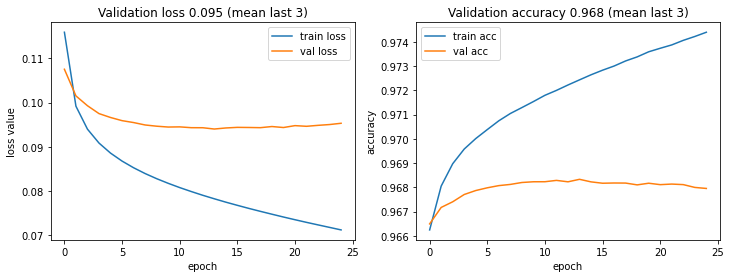

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 640)               819840    
_________________________________________________________________
dense_31 (Dense)             (None, 320)               205120    
_________________________________________________________________
dense_32 (Dense)             (None, 29)                9309      
Total params: 1,034,269
Trainable params: 1,034,269
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: , activation_3: , optimizer: sgd,
_________________________________________________________________





Train on 166720 samples, validate on 21760 samples
Epoch 1/25
166720/166720 [==============================] - 4s 24us/sample - loss: 0.1178 - acc: 0.9663 - val_loss: 0.10

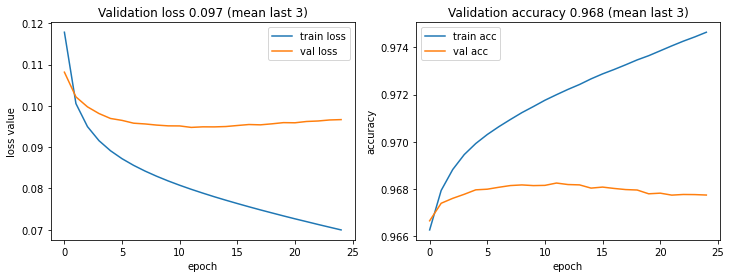

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 640)               819840    
_________________________________________________________________
dense_34 (Dense)             (None, 320)               205120    
_________________________________________________________________
dense_35 (Dense)             (None, 160)               51360     
_________________________________________________________________
dense_36 (Dense)             (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 3, activation_1: relu, activation_2: elu, activation_3: , optimizer: sgd,
_________________________________________________________________





Train on 166720 samples, validate o

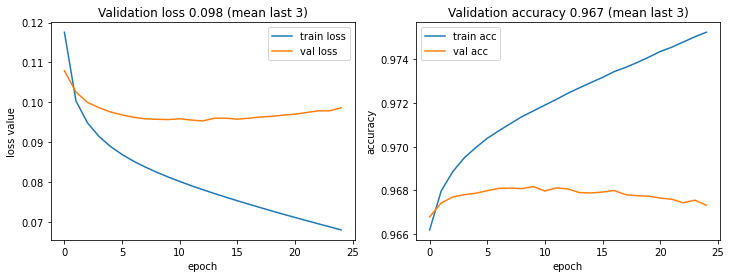

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 640)               819840    
_________________________________________________________________
dense_38 (Dense)             (None, 320)               205120    
_________________________________________________________________
dense_39 (Dense)             (None, 160)               51360     
_________________________________________________________________
dense_40 (Dense)             (None, 80)                12880     
_________________________________________________________________
dense_41 (Dense)             (None, 29)                2349      
Total params: 1,091,549
Trainable params: 1,091,549
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 4, activation_1: relu, activation_2: selu, activ

In [13]:
# set the labelling catagories
catagories = styles

# experiment with values
model_test(1, group = TILES, target = STYLE,                                                                     optimizer_name = "sgd")
model_test(2, group = TILES, target = STYLE, activation_1 = "relu",                                              optimizer_name = "sgd")
model_test(3, group = TILES, target = STYLE, activation_1 = "relu", activation_2 = "elu",                        optimizer_name = "sgd")
model_test(4, group = TILES, target = STYLE, activation_1 = "relu", activation_2 = "selu", activation_3 = "elu", optimizer_name = "sgd")

Here are some examples using the __PALETTES__ data to find __STYLES__.

Train on 166720 samples, validate on 21760 samples
Epoch 1/25
166720/166720 [==============================] - 3s 19us/sample - loss: 0.1391 - acc: 0.9656 - val_loss: 0.1258 - val_acc: 0.9662
Epoch 2/25
166720/166720 [==============================] - 3s 18us/sample - loss: 0.1155 - acc: 0.9673 - val_loss: 0.1160 - val_acc: 0.9669
Epoch 3/25
166720/166720 [==============================] - 3s 19us/sample - loss: 0.1074 - acc: 0.9681 - val_loss: 0.1111 - val_acc: 0.9672
Epoch 4/25
166720/166720 [==============================] - 3s 19us/sample - loss: 0.1026 - acc: 0.9686 - val_loss: 0.1079 - val_acc: 0.9673
Epoch 5/25
166720/166720 [==============================] - 3s 18us/sample - loss: 0.0991 - acc: 0.9690 - val_loss: 0.1054 - val_acc: 0.9675
Epoch 6/25
166720/166720 [==============================] - 3s 18us/sample - loss: 0.0965 - acc: 0.9693 - val_loss: 0.1036 - val_acc: 0.9676
Epoch 7/25
166720/166720 [==============================] - 3s 18us/sample - loss: 0.0944 - acc: 0.9695

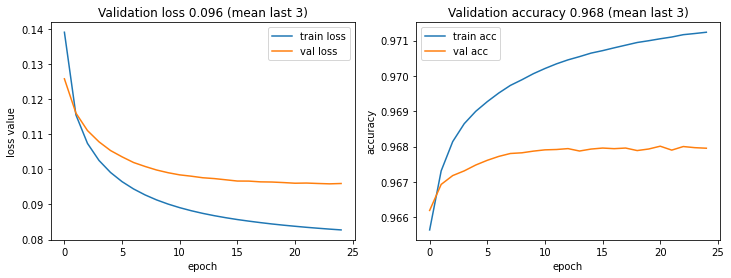

Test loss: 0.13
Test accuracy: 96.55%
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 29)                37149     
_________________________________________________________________
dense_43 (Dense)             (None, 29)                870       
Total params: 38,019
Trainable params: 38,019
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: , activation_2: , activation_3: , optimizer: sgd,
_________________________________________________________________





Train on 166720 samples, validate on 21760 samples
Epoch 1/25
166720/166720 [==============================] - 4s 24us/sample - loss: 0.1165 - acc: 0.9662 - val_loss: 0.1071 - val_acc: 0.9667
Epoch 2/25
166720/166720 [==============================] - 4s 23us/sample - loss: 0.0995 - acc: 0.9680 - val_loss: 0.10

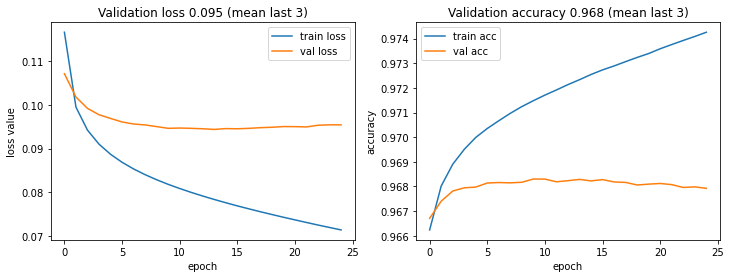

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 640)               819840    
_________________________________________________________________
dense_45 (Dense)             (None, 320)               205120    
_________________________________________________________________
dense_46 (Dense)             (None, 29)                9309      
Total params: 1,034,269
Trainable params: 1,034,269
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: , activation_3: , optimizer: sgd,
_________________________________________________________________





Train on 166720 samples, validate on 21760 samples
Epoch 1/25
166720/166720 [==============================] - 4s 25us/sample - loss: 0.1186 - acc: 0.9662 - val_loss: 0.1

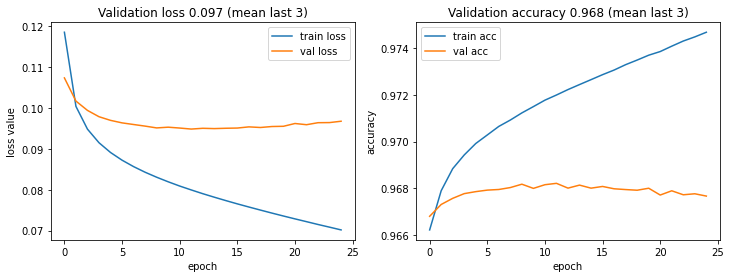

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 640)               819840    
_________________________________________________________________
dense_48 (Dense)             (None, 320)               205120    
_________________________________________________________________
dense_49 (Dense)             (None, 160)               51360     
_________________________________________________________________
dense_50 (Dense)             (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 3, activation_1: relu, activation_2: elu, activation_3: , optimizer: sgd,
_________________________________________________________________





Train on 166720 samples, validate o

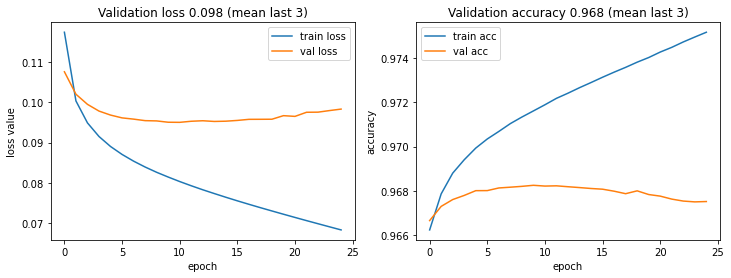

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 640)               819840    
_________________________________________________________________
dense_52 (Dense)             (None, 320)               205120    
_________________________________________________________________
dense_53 (Dense)             (None, 160)               51360     
_________________________________________________________________
dense_54 (Dense)             (None, 80)                12880     
_________________________________________________________________
dense_55 (Dense)             (None, 29)                2349      
Total params: 1,091,549
Trainable params: 1,091,549
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 4, activation_1: relu, activation_2: selu, activ

In [14]:
# set the labelling catagories
catagories = styles

# experiment with values
model_test(1, group = TILES, target = STYLE,                                                                     optimizer_name = "sgd")
model_test(2, group = TILES, target = STYLE, activation_1 = "relu",                                              optimizer_name = "sgd")
model_test(3, group = TILES, target = STYLE, activation_1 = "relu", activation_2 = "elu",                        optimizer_name = "sgd")
model_test(4, group = TILES, target = STYLE, activation_1 = "relu", activation_2 = "selu", activation_3 = "elu", optimizer_name = "sgd")